In [2]:
import pickle
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from qiskit import  QuantumCircuit, transpile
import random

In [3]:
n_qubits = 5

baseline_dirs = [f'{n_qubits}', f'{n_qubits}_app',]
quct_dirs = [f'{n_qubits}_test/result', '5_app/result']
n_neighbors = 7

In [4]:
# n_qubits = 4

# baseline_dirs = [f'{n_qubits}', ]
# quct_dirs = [f'5_app/result',]
# n_neighbors = 10 # 后面加到判断里面

In [5]:
linear = True

In [6]:
baseline_results = []

dir_files = []

for baseline_dir in baseline_dirs:
    for dirpath, dirnames, filenames in os.walk(baseline_dir):
        for filename in filenames:
            if 'json' not in filename or 'pkl' in filename:
                continue

            if (linear and 'linear' not in filename) or (not linear and 'linear' in filename):
                continue

            print(filename)
            with open(os.path.join(dirpath, filename), mode='r') as f:
                result_dict = json.load(f)
            baseline_results.append(result_dict)


for result_dict in baseline_results:
    picked_unitary = json.loads(result_dict['Unitary']).encode('latin-1')
    U = pickle.loads(picked_unitary)
    result_dict['U'] = U

linear_random-5-5.json
linear_random-5-2.json
linear_random-5-4.json
linear_random-5-3.json
linear_random-5-0.json
linear_random-5-1.json
linear-random-5-3.json
linear_random-5-8.json
linear_random-5-4.json
linear-random-5-1.json
linear-random-5-2.json


In [7]:
baseline_results[0].keys(), baseline_results[0]['Metrics'][0].keys()

(dict_keys(['Experiment Name', 'Unitary', 'Num of Qubits', 'Metrics', 'U']),
 dict_keys(['Synthesiser', 'Circuit', 'Execution Time', 'CNOT Count', 'Depth', 'Parallelism', 'CPU time', 'gate_num']))

In [8]:
synthesized_filenames = []
results = []

for quct_dir in quct_dirs:
    for dirpath, dirnames, filenames in os.walk(quct_dir):
        for filename in filenames:
            if 'pkl' not in filename or f'-{n_qubits}-' not in filename:  # 'change_func' not in filename or
                continue
            
            if (linear and 'linear' not in filename) or (not linear and 'linear' in filename):
                continue

            print(filename)
            with open(os.path.join(dirpath, filename), mode='rb') as f:
                result_dict = pickle.load(f)
            
            result_dict['baseline_name'] =  filename.split('_')[2]
            results.append(result_dict)
        

True_5_linear_random-5-5.json_2_7.pkl


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


True_5_linear_random-5-0.json_2_7.pkl
True_5_linear_random-5-1.json_2_7.pkl
True_5_linear_random-5-4.json_2_7.pkl
True_5_linear_random-5-3.json_2_7.pkl
True_5_linear_random-5-2.json_2_7.pkl
True_5_linear_random-5-8.json_2_7.pkl
True_5_linear_random-5-4.json_2_7.pkl
True_5_linear-random-5-2.json_2_7.pkl
True_5_linear-random-5-3.json_2_7.pkl
True_5_linear-random-5-1.json_2_7.pkl


In [9]:
results[0].keys()

dict_keys(['n_qubits', 'U', 'qiskit circuit', '#gate', '#two-qubit gate', 'depth', 'cpu time', 'use heuristic', 'n_unitary_candidates', 'n_neighbors', 'print', 'heuristic_takeeffect_count', 'heuristic_takeeffect_prob', 'iter_count', 'synthesis_time', 'baseline_name'])

In [10]:
merge_results = []
for quct_result in results:
    U = quct_result['U']

    corr_baseline_result = None
    for baseline_result in baseline_results:
        # print(baseline_result['U'].shape[0],  2**n_qubits, U.shape)
        if baseline_result['U'].shape[0] !=  2**n_qubits or np.allclose(U, baseline_result['U']):
            corr_baseline_result = baseline_result
            break
    
    if corr_baseline_result is None:
        print('don find')
        continue

    merge_result = {
        'U': U,
        'filename': quct_result['baseline_name'],
        'cpu_time': {},
        'time': {},
        '#two-qubit': {},
        '#gate': {},
        'depth': {},
    }

    # dict_keys(['n_qubits', 'U', 'qiskit circuit', '#gate', '#two-qubit gate', 'depth', 'cpu time', 'use heuristic', 'n_unitary_candidates', 'n_neighbors', 'print', 'heuristic_takeeffect_count', 
    # 'heuristic_takeeffect_prob', 'iter_count', 'synthesis_time'])

    merge_result['#two-qubit']['quct'] = quct_result['#two-qubit gate']
    merge_result['time']['quct'] = quct_result['synthesis_time']
    merge_result['#gate']['quct'] = quct_result['#gate']
    merge_result['depth']['quct'] = quct_result['depth']
    merge_result['cpu_time']['quct'] = quct_result['cpu time']

    if linear:
        merge_result['time']['quct'] /= 3
        merge_result['cpu_time']['quct'] /= 3

    # (dict_keys(['Experiment Name', 'Unitary', 'Num of Qubits', 'Metrics', 'U']),
    # dict_keys(['Synthesiser', 'Circuit', 'Execution Time', 'CNOT Count', 'Depth', 'Parallelism', 'CPU time', 'gate_num']))
        # baseline_name = metric['Synthesiser']
    for metric in corr_baseline_result['Metrics']:
        baseline_name = metric['Synthesiser'].replace(' Synthesiser', '').replace(' synthesiser', '')
        # print(baseline_name, metric)
        # print(metric.keys(), baseline_name)
        qiskit_circuit = QuantumCircuit.from_qasm_str(metric['Circuit'])
        if 'QFast' in baseline_name:
            qiskit_circuit = transpile(qiskit_circuit, optimization_level=3, basis_gates=['u', 'cz'])

        merge_result['#two-qubit'][baseline_name] = metric['CNOT Count']
        merge_result['time'][baseline_name] = metric['Execution Time']
        merge_result['#gate'][baseline_name] = len(qiskit_circuit)#metric['gate_num']
        merge_result['depth'][baseline_name] = qiskit_circuit.depth()

        '''为什么会有没有的'''
        merge_result['cpu_time'][baseline_name] = metric.get('CPU time', metric['Execution Time'] )
        if 'QFast' in baseline_name:
            merge_result['cpu_time'][baseline_name] *= 7
            if n_qubits == 4:
                merge_result['cpu_time'][baseline_name] *= 7
                merge_result['time'][baseline_name] *= 7


    merge_results.append(merge_result)
    

In [11]:
merge_result['U'] = None
merge_result['n_qubits'] = n_qubits
merge_result

{'U': None,
 'filename': 'linear-random-5-1.json',
 'cpu_time': {'quct': 9283.384777828858,
  'QFast': 1176378.48939538,
  'Qiskit': 3.1727941036224365,
  'CSD': 4.0493292808532715,
  'QSD': 2.0268161296844482},
 'time': {'quct': 3693.5675996144614,
  'QFast': 168035.013682127,
  'Qiskit': 3.1727941036224365,
  'CSD': 4.0493292808532715,
  'QSD': 2.0268161296844482},
 '#two-qubit': {'quct': 225,
  'QFast': 294,
  'Qiskit': 444,
  'CSD': 960,
  'QSD': 528},
 '#gate': {'quct': 680,
  'QFast': 887,
  'Qiskit': 1145,
  'CSD': 1922,
  'QSD': 1376},
 'depth': {'quct': 341, 'QFast': 457, 'Qiskit': 869, 'CSD': 1758, 'QSD': 1027},
 'n_qubits': 5}

In [12]:
merge_results[0]

{'U': array([[ 0.10506419-0.20190896j, -0.02573663+0.02349326j,
          0.09143217-0.05394369j, ...,  0.06758441-0.09542563j,
         -0.02548947+0.04332046j, -0.03253214-0.24036042j],
        [ 0.08403804-0.20702616j,  0.13222695+0.05297873j,
          0.05223096+0.07579703j, ...,  0.09970232-0.03361332j,
         -0.06234914-0.01219741j,  0.09182946+0.08413286j],
        [-0.15372683+0.17477916j,  0.31419312-0.04090555j,
          0.02717591-0.03308452j, ..., -0.05516073-0.05081292j,
         -0.17536224-0.10727934j,  0.17917496+0.04928978j],
        ...,
        [ 0.07861519-0.01398585j,  0.03752073+0.16536901j,
         -0.02788094+0.09012281j, ...,  0.28248191-0.08471543j,
         -0.05475923-0.20858553j,  0.01233148-0.07233723j],
        [ 0.01087099+0.02057404j, -0.18153053-0.16628846j,
         -0.14716881-0.16543025j, ..., -0.22551314-0.05792361j,
          0.11204515-0.14325404j, -0.13130733+0.15590164j],
        [-0.02916238-0.14845946j, -0.04214242-0.01972653j,
        

In [13]:
all_result_df_data = []
evaluated_baselines = []

syn_index = {
    'quct': 0,
    'QFast': 1,
    'DNN': 2,
    'Qiskit': 3,
    'QSD': 4,
    # 'CSD': 4,
} # 用来让作图的顺序固定的

for merge_result in merge_results:
    for prop_name in merge_result:
        if prop_name in ('U', 'filename', 'n_qubits'):
            continue
        for synthesizer, prop_value in merge_result[prop_name].items():
            if synthesizer not in syn_index:
                continue

            all_result_df_data.append([synthesizer, prop_name, prop_value])

all_result_df_data.sort(key = lambda elm: syn_index[elm[0]])

if n_qubits == 4:
    for i in range(10):
        all_result_df_data.append(['DNN', 'cpu_time', 169*60*60*(random.random()*.5+.8)])
        all_result_df_data.append(['DNN', 'time', 169*60*60*(random.random()*.5+.8)])
        all_result_df_data.append(['DNN', '#two-qubit', 90*(random.random()*.5+.8)])
        all_result_df_data.append(['DNN', '#gate', 500*(random.random()*.5+.8)])
        all_result_df_data.append(['DNN', 'depth', 150*(random.random()*.5+.8)])

len(all_result_df_data)
all_result_df = pd.DataFrame(all_result_df_data, columns=['synthesizer', 'property', 'value'])
all_result_df


,synthesizer,property,value
0,quct,cpu_time,7089.602990
1,quct,time,2902.538563
2,quct,#two-qubit,243.000000
3,quct,#gate,734.000000
4,quct,depth,399.000000
...,...,...,...
135,QSD,cpu_time,2.026816
136,QSD,time,2.026816
137,QSD,#two-qubit,528.000000
138,QSD,#gate,1376.000000


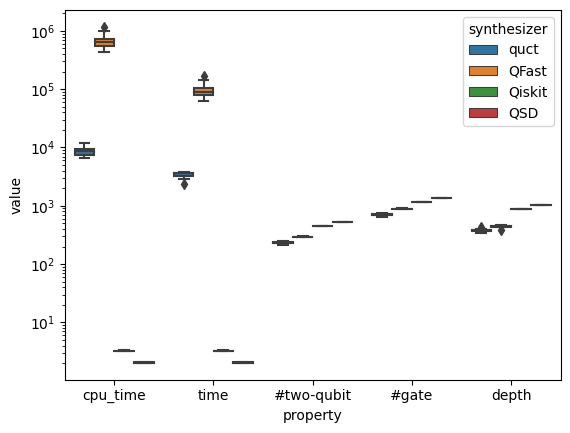

In [14]:
ax = sns.boxplot(x="property", y="value", hue="synthesizer", data=all_result_df)  # RUN PLOT  
ax.set_yscale('log')

In [15]:
for prop_name in ['#two-qubit', 'time', '#gate', 'depth', 'cpu_time']:
    prop_df = all_result_df[all_result_df['property'] == prop_name]

    qfast_df =  np.array(prop_df[prop_df['synthesizer'] == 'QFast']['value'])
    quct =  np.array(prop_df[prop_df['synthesizer'] == 'quct']['value'])

    quct = quct[:len(qfast_df)]
    print(prop_name, float(qfast_df.mean() / quct.mean()),  float(quct.mean() / qfast_df.mean()))
    # print(prop_name, float((qfast_df / quct).mean()),  float( (quct / qfast_df).mean()))

'''似乎还会有qfast没有quct有的'''

#two-qubit 1.266796875 0.7893925377736664
time 28.50855108546677 0.03507719480383501
#gate 1.2648998060762768 0.7905764513491413
depth 1.160307175425966 0.8618407445708376
cpu_time 79.69945278729043 0.012547137590378397


'似乎还会有qfast没有quct有的'

In [16]:
len(quct)

11

In [17]:
len(qfast_df)

11

In [18]:
qfast_df =  prop_df[prop_df['synthesizer'] == 'QFast']
qfast_df.mean()

/tmp/ipykernel_2759098/569752527.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  qfast_df.mean()


value    683679.122396
dtype: float64

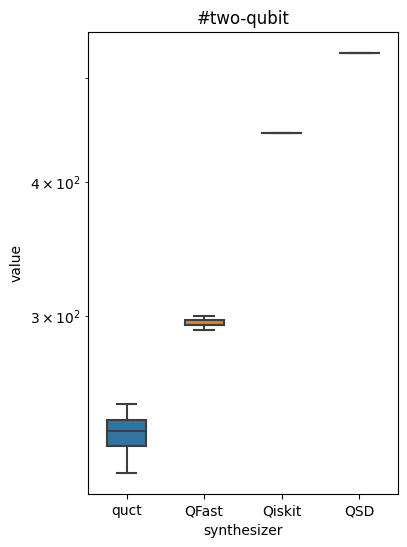

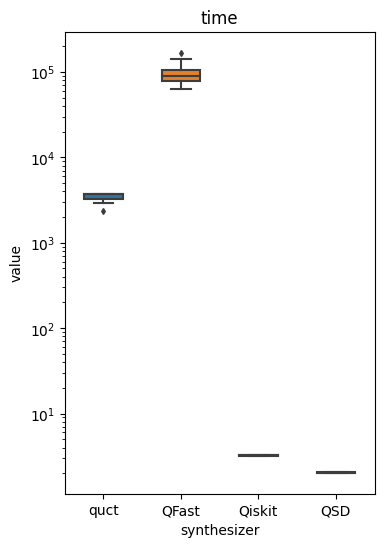

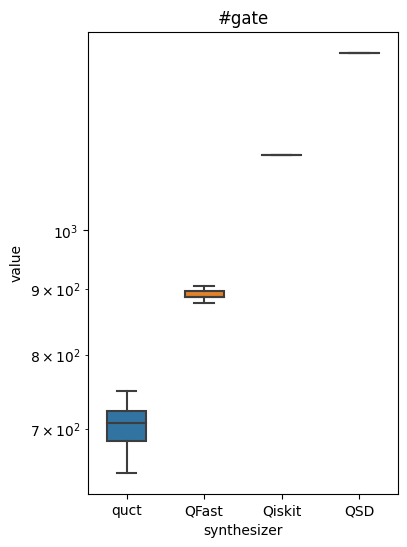

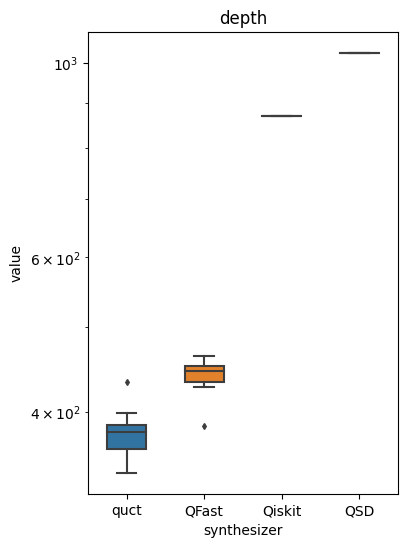

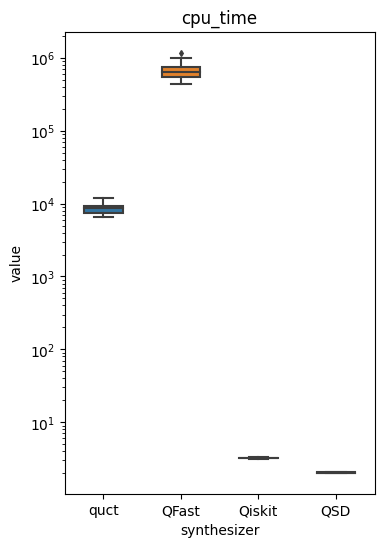

In [19]:
for prop_name in ['#two-qubit', 'time', '#gate', 'depth', 'cpu_time']:
    fig, ax = plt.subplots(figsize =(4,6))

    plot_data = all_result_df[all_result_df['property'] == prop_name]
    ax = sns.boxplot(x="synthesizer", y="value", data=plot_data, fliersize=3, width =.5)  # RUN PLOT
    plt.title(prop_name)
    ax.set_yscale('log')
    fig.show()
    fig.savefig(f'synthesis_evaluation_fig/qubit{n_qubits}_{prop_name}_{"linear" if linear else ""}.svg')

   Trial Number     value
0      1      1 -0.750615
1      1      1 -1.715070
2      1      1 -0.963404
3      1      1  0.360856
4      1      1 -1.190504


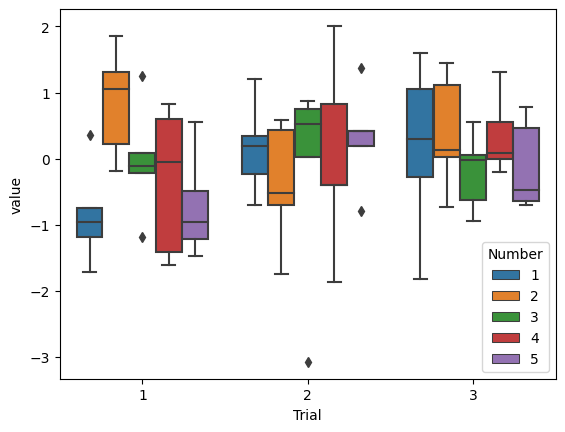

In [20]:
np.random.seed(44)
# DATAFRAMES WITH TRIAL COLUMN ASSIGNED
df1 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=1)
df2 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=2)
df3 = pd.DataFrame(np.random.randn(5,5), columns=list(range(1,6))).assign(Trial=3)

cdf = pd.concat([df1, df2, df3])                                # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Trial'], var_name=['Number'])      # MELT

print(mdf.head())
#    Trial Number     value
# 0      1      1 -0.750615
# 1      1      1 -1.715070
# 2      1      1 -0.963404
# 3      1      1  0.360856
# 4      1      1 -1.190504

ax = sns.boxplot(x="Trial", y="value", hue="Number", data=mdf)  # RUN PLOT  
plt.show()

plt.clf()
plt.close()